In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

$$d{\Pi_{s}} = \kappa_{\Pi} \left(\theta_{\Pi}(s) + \frac{1}{\kappa_{\Pi}} \frac{d\theta_{\Pi}}{ds}(s) - \Pi_s\right) ds + \sigma_{\Pi, v} \Pi_s dB_{v, s} + \sigma_{\Pi, \Pi} \Pi_s dB_{\Pi, s}$$

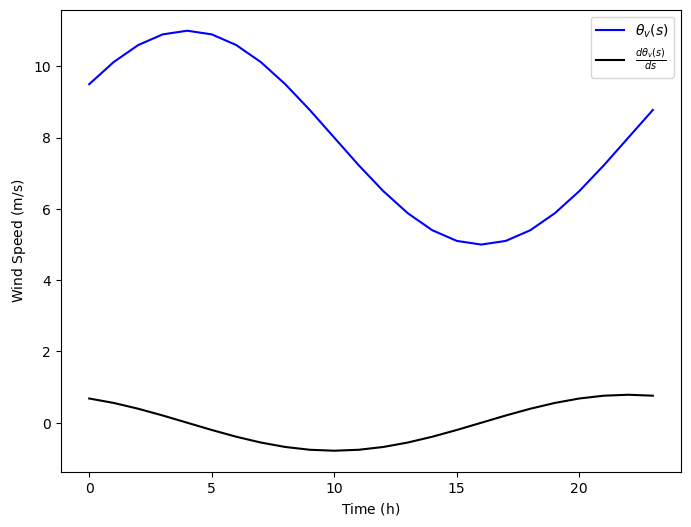

In [3]:
T = 24
h = 1
N = int(T / h)
k_pi = 0.04 / h
sigma_pi_v = 0.01
sigma_pi_pi = 0.075

theta_v_bar = 8
alpha_v = 0.375
gamma = np.pi / (12 * h)
psi_v = 2 / h

theta_v = lambda s: theta_v_bar * (1 + alpha_v * np.sin(gamma*(s + psi_v)))
dtheta_v = lambda s: theta_v_bar * alpha_v * np.cos(gamma * (s + psi_v)) * gamma
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, T, h), theta_v(np.arange(0, T, h)), color = "blue", label = r'$\theta_v(s)$')
plt.plot(np.arange(0, T, h), dtheta_v(np.arange(0, T, h)), color = "black", label = r'$\frac{d\theta_v(s)}{ds}$')
plt.xlabel(r'$\text{Time (h)}$')
plt.ylabel(r'$\text{Wind Speed (m/s)}$')
plt.legend()
plt.show()

In [4]:
def price_sde(T, h, k_pi, sigma_pi_v, sigma_pi_pi):

    '''
    Simulation of the price process

    Inputs: 
    T: total time
    h: time step size
    k_pi: mean reversion rate for price
    sig_pi_v: correlation of electricity price and wind speed
    sig_pi_pi: volatility of the price process
    wind_BM: standard brownian motion for the wind power
    price_BM: standard brownian motion for the spot price

    Output:
    A matrix contains the price of electricity at each time point
    '''

    N = int(T/h)
    cov = np.reshape(np.array([1, 0, 0, 1]), (2,2))
    brownianmotion = np.random.multivariate_normal([0,0], cov, size=N)

    theta_v = lambda s: theta_v_bar * (1 + alpha_v * np.sin(gamma*(s + psi_v)))
    dtheta_v = lambda s: theta_v_bar * alpha_v * np.cos(gamma * (s + psi_v)) * gamma

    s = 0 
    price = np.zeros(N + 1)
    price[0] = np.random.normal(theta_v(0), 0.075)
    
    for i in range(1, N + 1):
        price[i] = price[i - 1] + k_pi * (theta_v(s) + 1/k_pi * dtheta_v(s) - price[i - 1]) * h \
            + np.sqrt(h) * sigma_pi_v * price[i - 1] * brownianmotion[i-1, 0] \
            + np.sqrt(h) * sigma_pi_pi * price[i-1] * brownianmotion[i-1, 1]
        s += h
    return price



In [6]:
T = 24
h = 1
k_pi = 0.04 / h
sigma_pi_v = 0.01
sigma_pi_pi = 0.075
price_process = price_sde(T, h, k_pi, sigma_pi_v, sigma_pi_pi)
price_process



array([ 9.5614066 , 10.00558357, 10.60933109, 10.48012728, 10.93791533,
       10.70670995,  9.60928737,  9.63807848,  9.53866432,  8.60828528,
        8.09787908,  7.83534976,  6.96137586,  6.81263148,  6.88433687,
        5.89012781,  4.39098343,  4.50921722,  4.65399345,  4.72958789,
        5.95583765,  6.77328302,  7.5838876 ,  8.83073126, 10.28727104])

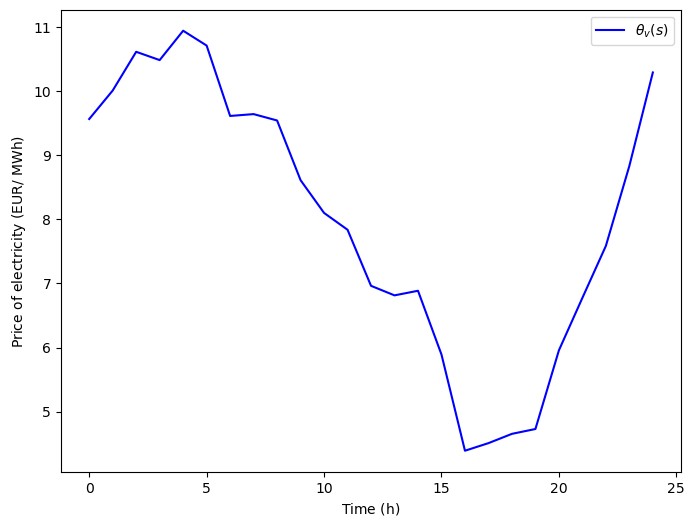

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, T+h, h), price_process, color = "blue", label = r'$\theta_v(s)$')
plt.xlabel(r'$\text{Time (h)}$')
plt.ylabel(r'$\text{Price of electricity (EUR/ MWh)}$')
plt.legend()
plt.show()

In [11]:
# simulations
h = 0.1
simulation_times = 1000
prices = np.zeros(simulation_times * (int(T / h) + 1))
prices = np.reshape(prices, (simulation_times, int(T/h) + 1))
for i in range(simulation_times):
    prices[i] = price_sde(T, h, k_pi, sigma_pi_v, sigma_pi_pi)
expected_value = np.mean(prices, axis=0)
# print(expected_value)

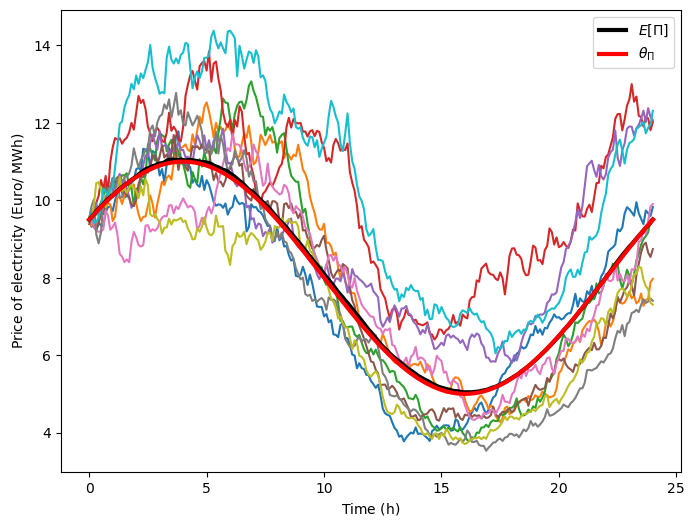

In [10]:
# print(prices)
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(np.arange(0, T+h, h), prices[i])
plt.plot(np.arange(0, T+h, h), expected_value, color='black', linewidth = 3, label=r'$E[\Pi]$')
plt.plot(np.arange(0, T+h, h), theta_v(np.arange(0, T+h, h)), color="red", linewidth = 3, label = r'$\theta_{\Pi}$')
plt.xlabel(r'$\text{Time (h)}$')
plt.ylabel(r'$\text{Price of electricity (Euro/ MWh)}$')
plt.legend()
plt.show()